In [1]:
import sys
sys.path.append('../Shared_dir')

import feature_engineering_scaling as fes 
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score
import joblib

2024-11-16 15:49:07.226988: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-16 15:49:07.947333: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-16 15:49:10.771889: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


DECISION TREE MODEL

In [2]:
# Define a function to train and evaluate a decision tree
def train_and_evaluate_decision_tree(X_train, y_train, X_val, y_val, X_test, y_test):
    # Initialize the Decision Tree Classifier
    model = DecisionTreeClassifier(random_state=0)
    
    # Train the model on the training data
    model.fit(X_train, y_train)
    
    # Evaluate on validation set
    y_val_pred = model.predict(X_val)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    print("Validation Accuracy:", val_accuracy)
    print("Validation Classification Report:")
    print(classification_report(y_val, y_val_pred))
    
    # Evaluate on test set
    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    print("Test Accuracy:", test_accuracy)
    print("Test Classification Report:")
    print(classification_report(y_test, y_test_pred))
    
    return model


In [3]:
#Since the truth need not be one hot encoded for decision tree, spliting of the dataset is done here
X1_train, X1_test, y1_train, y1_test = train_test_split(fes.X1, fes.y1, test_size=0.2, random_state=0)
X1_train, X1_val, y1_train, y1_val = train_test_split(X1_train, y1_train, test_size=0.2, random_state=0)
X2_train, X2_test, y2_train, y2_test = train_test_split(fes.X2, fes.y2, test_size=0.2, random_state=0)
X2_train, X2_val, y2_train, y2_val = train_test_split(X2_train, y2_train, test_size=0.2, random_state=0)

In [4]:
# Model for the First Chain (BiPo214)
print("Training and evaluating Decision Tree on First Chain")
model_dt_1 = train_and_evaluate_decision_tree(X1_train, y1_train, X1_val, y1_val, X1_test, y1_test)

Training and evaluating Decision Tree on First Chain
Validation Accuracy: 0.7113305009009218
Validation Classification Report:
              precision    recall  f1-score   support

         0.0       0.69      0.70      0.69    344639
         1.0       0.52      0.52      0.52    347579
         2.0       1.00      1.00      1.00    345602
         3.0       0.64      0.62      0.63    345208

    accuracy                           0.71   1383028
   macro avg       0.71      0.71      0.71   1383028
weighted avg       0.71      0.71      0.71   1383028

Test Accuracy: 0.7117042961989468
Test Classification Report:
              precision    recall  f1-score   support

         0.0       0.69      0.70      0.69    431339
         1.0       0.52      0.52      0.52    432713
         2.0       1.00      1.00      1.00    433475
         3.0       0.64      0.62      0.63    431257

    accuracy                           0.71   1728784
   macro avg       0.71      0.71      0.71   1728

In [5]:
# Model for the Second Chain (BiPo212)
print("Training and evaluating Decision Tree on 2nd Dataset")
model_dt_2 = train_and_evaluate_decision_tree(X2_train, y2_train, X2_val, y2_val, X2_test, y2_test)


Training and evaluating Decision Tree on 2nd Dataset
Validation Accuracy: 0.738353606144386
Validation Classification Report:
              precision    recall  f1-score   support

         0.0       0.74      0.76      0.75    344691
         3.0       0.64      0.63      0.63    345046
         4.0       0.57      0.57      0.57    338881
         5.0       1.00      1.00      1.00    340046

    accuracy                           0.74   1368664
   macro avg       0.74      0.74      0.74   1368664
weighted avg       0.74      0.74      0.74   1368664

Test Accuracy: 0.7384082579800447
Test Classification Report:
              precision    recall  f1-score   support

         0.0       0.74      0.76      0.75    432071
         3.0       0.64      0.63      0.63    431059
         4.0       0.57      0.57      0.57    424809
         5.0       1.00      1.00      1.00    422891

    accuracy                           0.74   1710830
   macro avg       0.74      0.74      0.74   17108

GRID SEARCH

In [6]:
# Now to fnd the best hyperparameters for the best model, define the GridSearch function
def perform_grid_search(X_train, y_train, param_grid):
    # Initialize the Decision Tree model
    dt = DecisionTreeClassifier(random_state=0)
    
    # Set up GridSearchCV with cross-validation
    grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=2)
    
    # Perform the grid search on the training data
    grid_search.fit(X_train, y_train)
    
    # Output the best parameters and best score
    print("Best Parameters:", grid_search.best_params_)
    print("Best Cross-Validation Accuracy:", grid_search.best_score_)
    
    return grid_search.best_estimator_

In [7]:
# Define a function to plot the confusion matrix
def plot_confusion_matrix(model, X_test, y_test, subset_name):
    # If y_test is one-hot encoded, convert it to label format
    if len(y_test.shape) > 1 and y_test.shape[1] > 1:
        y_test_labels = y_test.argmax(axis=1)  # Convert one-hot encoded to labels
    else:
        y_test_labels = y_test

    # Get predictions
    y_pred = model.predict(X_test)

    # Compute confusion matrix
    cm = confusion_matrix(y_test_labels, y_pred)

    # Get unique class labels for display
    display_labels = [str(cls) for cls in sorted(set(y_test_labels))]

    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix for {subset_name}")
    plt.show()

In [8]:
# Define a function to calculate and display precision, recall, and F1 score
def evaluate_model_performance(model, X_test, y_test, subset_name):
    # Get true labels and predictions
    y_pred = model.predict(X_test)
    
    # Calculate weighted, macro, and micro precision, recall, and F1 score
    precision_weighted = precision_score(y_test, y_pred, average='weighted')
    recall_weighted = recall_score(y_test, y_pred, average='weighted')
    f1_weighted = f1_score(y_test, y_pred, average='weighted')
    
    precision_macro = precision_score(y_test, y_pred, average='macro')
    recall_macro = recall_score(y_test, y_pred, average='macro')
    f1_macro = f1_score(y_test, y_pred, average='macro')
    
    precision_micro = precision_score(y_test, y_pred, average='micro')
    recall_micro = recall_score(y_test, y_pred, average='micro')
    f1_micro = f1_score(y_test, y_pred, average='micro')
    
    # Display the results
    print(f"Performance Metrics for {subset_name}:")
    print(f"Precision (Weighted): {precision_weighted:.4f}")
    print(f"Recall (Weighted): {recall_weighted:.4f}")
    print(f"F1 Score (Weighted): {f1_weighted:.4f}")
    print()
    print(f"Precision (Macro): {precision_macro:.4f}")
    print(f"Recall (Macro): {recall_macro:.4f}")
    print(f"F1 Score (Macro): {f1_macro:.4f}")
    print()
    print(f"Precision (Micro): {precision_micro:.4f}")
    print(f"Recall (Micro): {recall_micro:.4f}")
    print(f"F1 Score (Micro): {f1_micro:.4f}")
    print()

In [9]:
# Define the hyperparameter grid for Grid Search
param_grid = {
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
}

Grid Search For BiPo214

In [10]:
# Perform Grid Search for BiPo 214
print("Performing Grid Search for BiPo 214")
best_dt_model_1 = perform_grid_search(X1_train, y1_train, param_grid)

Performing Grid Search for BiPo 214
Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2; total time= 3.0min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2; total time= 3.1min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5; total time= 3.1min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2; total time= 3.1min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5; total time= 2.9min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10; total time= 2.9min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10; total time= 3.0min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5; total time= 3.1min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10; total time= 2.9min
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2; total time= 2.8min
[CV] END max_depth=None, min_samples_leaf=2, min_

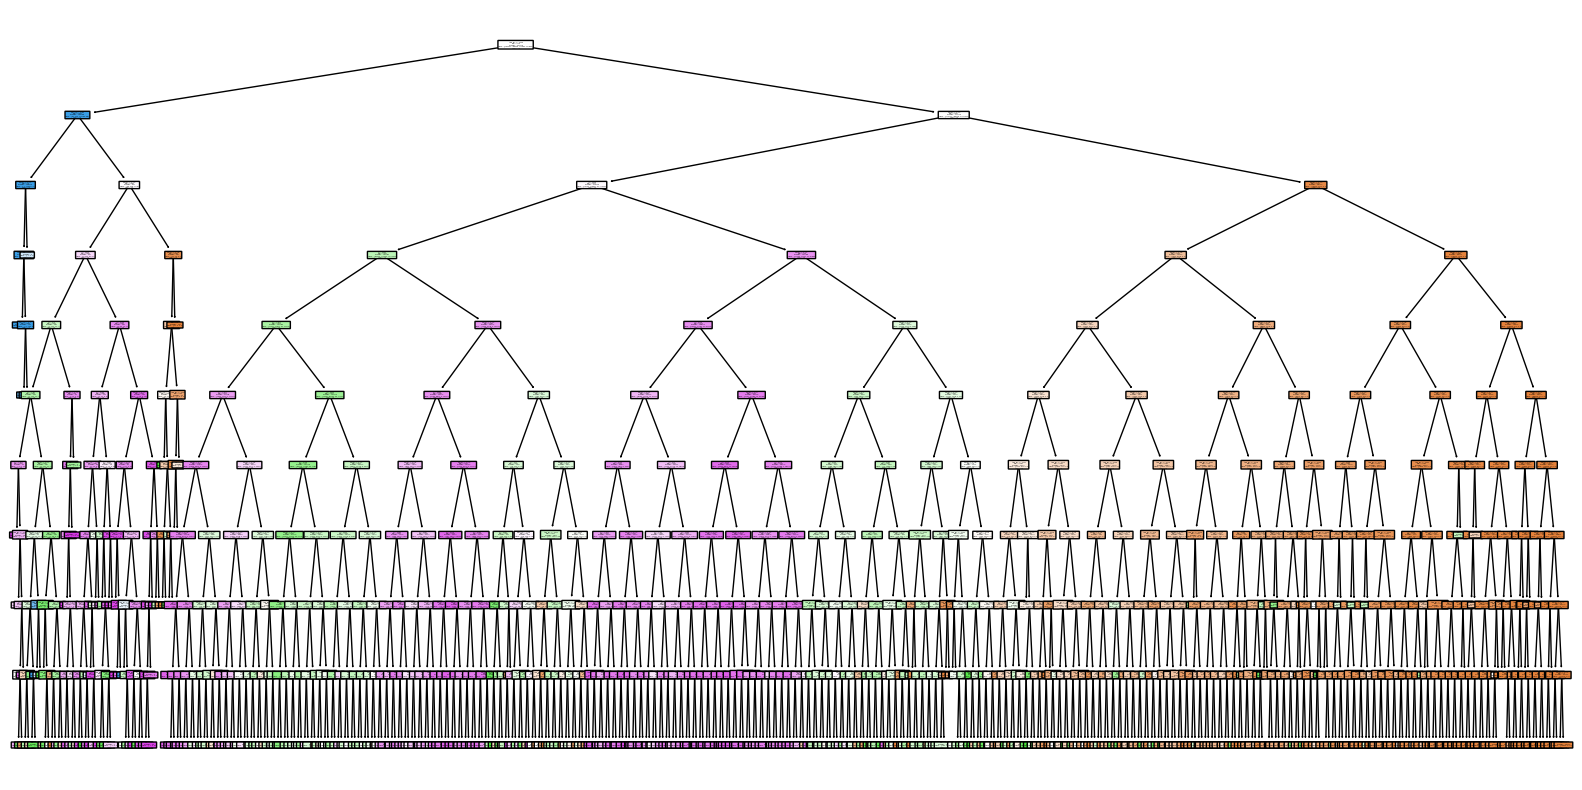

In [11]:
# Ensure feature names
feature_names = fes.X1.columns if isinstance(fes.X1, pd.DataFrame) else ["Feature_" + str(i) for i in range(fes.X1.shape[1])]

# Ensure class names
class_names = [str(cls) for cls in np.unique(fes.y1)]

# Plot the decision tree
plt.figure(figsize=(20, 10))
plot_tree(
    best_dt_model_1,
    feature_names=feature_names,
    class_names=class_names,
    filled=True,
    rounded=True
)
plt.show()

Confusion Matrix for Best Model for BiPo214 Test Set


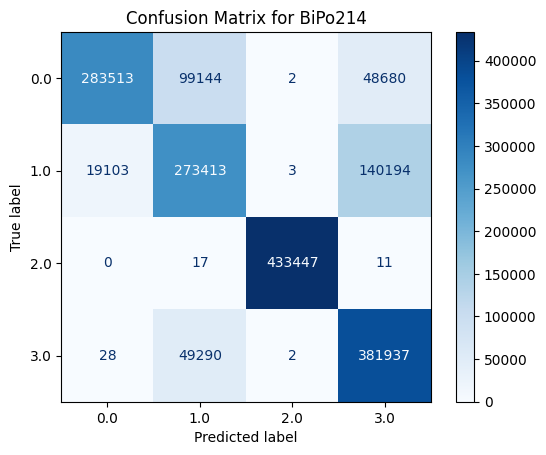

In [12]:
# Plot confusion matrix for BiPo214
print("Confusion Matrix for Best Model for BiPo214 Test Set")
plot_confusion_matrix(best_dt_model_1, X1_test, y1_test, "BiPo214")

In [13]:
# Evaluate for BiPo214
print("Evaluating Best Model for BiPo214 Test Set")
evaluate_model_performance(best_dt_model_1, X1_test, y1_test, "BiPo214")

Evaluating Best Model for BiPo214 Test Set
Performance Metrics for BiPo214:
Precision (Weighted): 0.8136
Recall (Weighted): 0.7938
F1 Score (Weighted): 0.7938

Precision (Macro): 0.8135
Recall (Macro): 0.7937
F1 Score (Macro): 0.7937

Precision (Micro): 0.7938
Recall (Micro): 0.7938
F1 Score (Micro): 0.7938



In [14]:
# Save the model to a file
joblib.dump(best_dt_model_1, 'model_decision_tree_214.pkl')

['model_decision_tree_214.pkl']

Grid Search for BiPo212

In [15]:
# Perform Grid Search for BiPo 212
print("Performing Grid Search for BiPo 212")
best_dt_model_2 = perform_grid_search(X2_train, y2_train, param_grid)

Performing Grid Search for BiPo 212
Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5; total time= 2.2min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2; total time= 2.3min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2; total time= 2.3min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2; total time= 2.4min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5; total time= 2.3min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10; total time= 2.2min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5; total time= 2.3min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10; total time= 2.3min
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10; total time= 2.2min
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2; total time= 2.2min
[CV] END max_depth=None, min_samples_leaf=2, min_

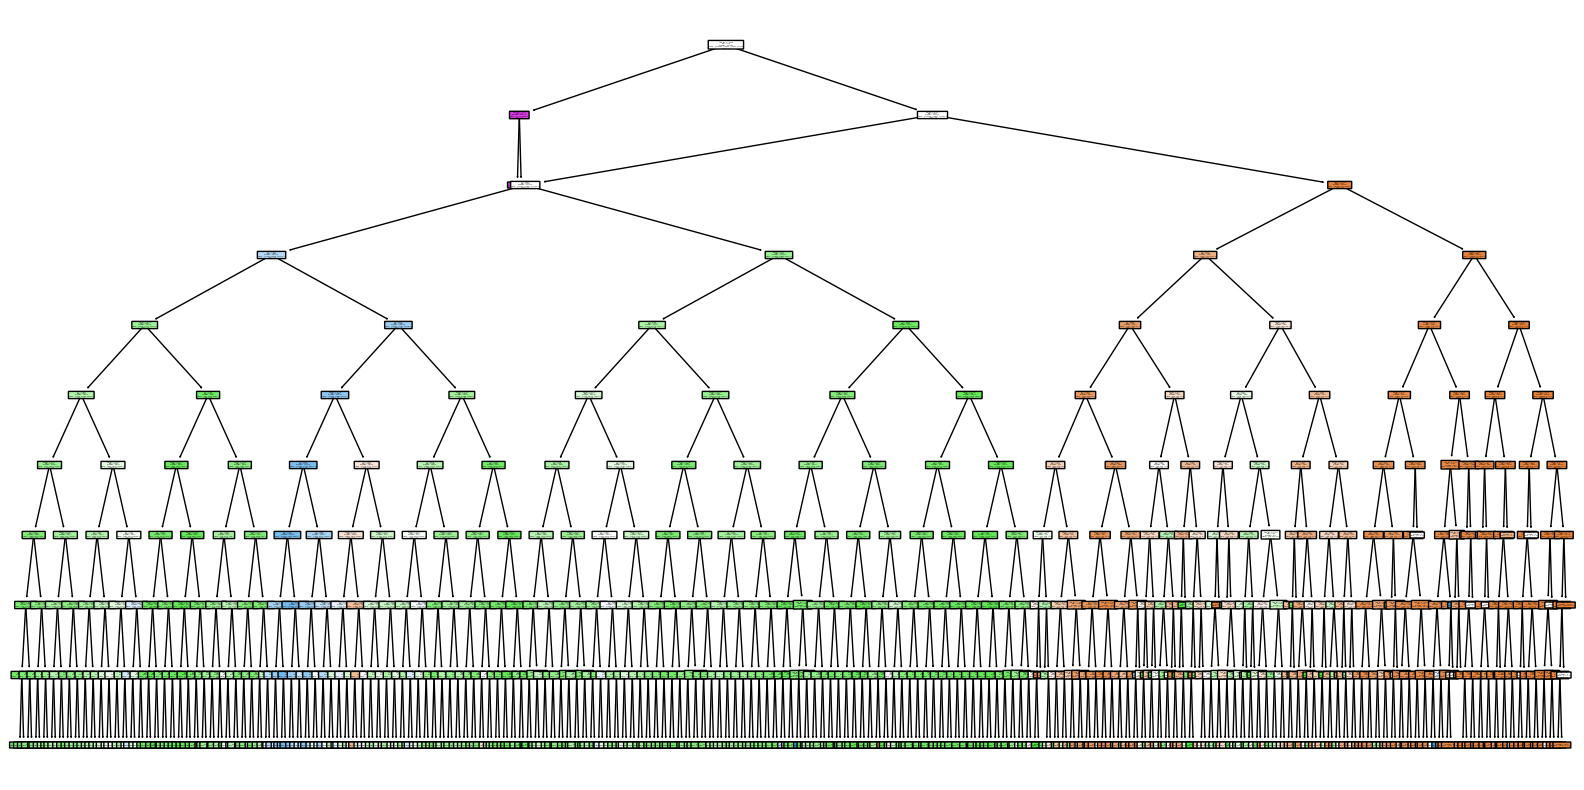

In [17]:
# Ensure feature names
feature_names = fes.X2.columns if isinstance(fes.X2, pd.DataFrame) else ["Feature_" + str(i) for i in range(fes.X2.shape[1])]

# Ensure class names
class_names = [str(cls) for cls in np.unique(fes.y2)]

# Plot the decision tree
plt.figure(figsize=(20, 10))
plot_tree(
    best_dt_model_2,
    feature_names=feature_names,
    class_names=class_names,
    filled=True,
    rounded=True
)
plt.show()

Confusion Matrix for Best Model for BiPo212 Test Set


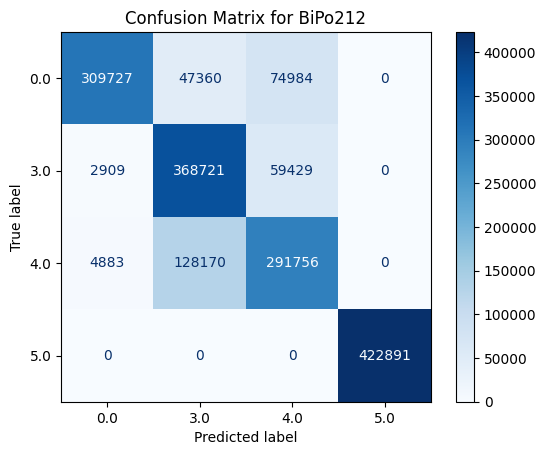

In [18]:
# Plot confusion matrix for BiPo212
print("Confusion Matrix for Best Model for BiPo212 Test Set")
plot_confusion_matrix(best_dt_model_2, X2_test, y2_test, "BiPo212")

In [19]:
# Evaluate for BiPo212
print("Evaluating Best Model for BiPo212 Test Set")
evaluate_model_performance(best_dt_model_2, X2_test, y2_test, "BiPo212")

Evaluating Best Model for BiPo212 Test Set
Performance Metrics for BiPo212:
Precision (Weighted): 0.8342
Recall (Weighted): 0.8143
F1 Score (Weighted): 0.8167

Precision (Macro): 0.8344
Recall (Macro): 0.8148
F1 Score (Macro): 0.8170

Precision (Micro): 0.8143
Recall (Micro): 0.8143
F1 Score (Micro): 0.8143



In [20]:
# Save the model to a file
joblib.dump(best_dt_model_1, 'model_decision_tree_214.pkl')

['model_decision_tree_214.pkl']